# 5. Dependency Parsing 

I recommend you take a look at these material first.

* http://web.stanford.edu/class/cs224n/lectures/cs224n-2017-lecture6.pdf
* http://cs.stanford.edu/people/danqi/papers/emnlp2014.pdf
* https://github.com/rguthrie3/DeepDependencyParsingProblemSet/tree/master/data

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import nltk
import random
import numpy as np
from collections import Counter, OrderedDict
import nltk
from nltk.tree import Tree
import os
from IPython.display import Image, display
from nltk.draw import TreeWidget
from nltk.draw.util import CanvasFrame
flatten = lambda l: [item for sublist in l for item in sublist]
random.seed(1024)

In [2]:
USE_CUDA = torch.cuda.is_available()
gpus = [0]
torch.cuda.set_device(gpus[0])

FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if USE_CUDA else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

In [3]:
def getBatch(batch_size, train_data):
    random.shuffle(train_data)
    sindex = 0
    eindex = batch_size
    while eindex < len(train_data):
        batch = train_data[sindex: eindex]
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        yield batch
    
    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch

In [4]:
def prepare_sequence(seq, to_index):
    idxs = list(map(lambda w: to_index[w] if to_index.get(w) is not None else to_index["<unk>"], seq))
    return Variable(LongTensor(idxs))

In [5]:
# Borrowed from https://stackoverflow.com/questions/31779707/how-do-you-make-nltk-draw-trees-that-are-inline-in-ipython-jupyter

def draw_nltk_tree(tree):
    cf = CanvasFrame()
    tc = TreeWidget(cf.canvas(), tree)
    tc['node_font'] = 'arial 15 bold'
    tc['leaf_font'] = 'arial 15'
    tc['node_color'] = '#005990'
    tc['leaf_color'] = '#3F8F57'
    tc['line_color'] = '#175252'
    cf.add_widget(tc, 50, 50)
    cf.print_to_file('tmp_tree_output.ps')
    cf.destroy()
    os.system('convert tmp_tree_output.ps tmp_tree_output.png')
    display(Image(filename='tmp_tree_output.png'))
    os.system('rm tmp_tree_output.ps tmp_tree_output.png')

## Transition State Class 

It tracks transition state(current stack, buffer) and extracts its feature for neural dependancy parser

<img src="../images/05.transition-based-parse.png">
<center>borrowed image from http://web.stanford.edu/class/cs224n/lectures/cs224n-2017-lecture6.pdf</center>

In [6]:
class TransitionState(object):
    
    def __init__(self, tagged_sent):
        self.root = ('ROOT', '<root>', -1)
        self.stack = [self.root]
        self.buffer = [(s[0], s[1], i) for i, s in enumerate(tagged_sent)]
        self.address = [s[0] for s in tagged_sent] + [self.root[0]]
        self.arcs = []
        self.terminal=False
        
    def __str__(self):
        return 'stack : %s \nbuffer : %s' % (str([s[0] for s in self.stack]), str([b[0] for b in self.buffer]))
    
    def shift(self):
        
        if len(self.buffer) >= 1:
            self.stack.append(self.buffer.pop(0))
        else:
            print("Empty buffer")
            
    def left_arc(self, relation=None):
        
        if len(self.stack) >= 2:
            arc = {}
            s2 = self.stack[-2]
            s1 = self.stack[-1]
            arc['graph_id'] = len(self.arcs)
            arc['form'] = s1[0]
            arc['addr'] = s1[2]
            arc['head'] = s2[2]
            arc['pos'] = s1[1]
            if relation:
                arc['relation'] = relation
            self.arcs.append(arc)
            self.stack.pop(-2)
            
        elif self.stack == [self.root]:
            print("Element Lacking")
    
    def right_arc(self, relation=None):
        
        if len(self.stack) >= 2:
            arc = {}
            s2 = self.stack[-2]
            s1 = self.stack[-1]
            arc['graph_id'] = len(self.arcs)
            arc['form'] = s2[0]
            arc['addr'] = s2[2]
            arc['head'] = s1[2]
            arc['pos'] = s2[1]
            if relation:
                arc['relation'] = relation
            self.arcs.append(arc)
            self.stack.pop(-1)
            
        elif self.stack == [self.root]:
            print("Element Lacking")
    
    def get_left_most(self, index):
        left=['<NULL>', '<NULL>', None]
        
        if index == None: 
            return left
        for arc in self.arcs:
            if arc['head'] == index:
                left = [arc['form'], arc['pos'], arc['addr']]
                break
        return left
    
    def get_right_most(self, index):
        right=['<NULL>', '<NULL>', None]
        
        if index == None: 
            return right
        for arc in reversed(self.arcs):
            if arc['head'] == index:
                right=[arc['form'], arc['pos'], arc['addr']]
                break
        return right
    
    def is_done(self):
        return len(self.buffer) == 0 and self.stack == [self.root]
    
    def to_tree_string(self):
        if self.is_done() == False: 
            return None
        ingredient = []
        for arc in self.arcs:
            ingredient.append([arc['form'], self.address[arc['head']]])
        ingredient = ingredient[-1:] + ingredient[:-1]
        return self._make_tree(ingredient, 0)
    
    def _make_tree(self, ingredient, i, new=True):
    
        if new:
            treestr = "("
            treestr += ingredient[i][0]
            treestr += " "
        else:
            treestr = ""
        ingredient[i][0] = "CHECK"

        parents,_ = list(zip(*ingredient))

        if ingredient[i][1] not in parents:
            treestr += ingredient[i][1]
            return treestr

        else:
            treestr += "("
            treestr += ingredient[i][1]
            treestr += " "
            for node_i, node in enumerate(parents):
                if node == ingredient[i][1]:
                    treestr += self._make_tree(ingredient, node_i, False)
                    treestr += " "

            treestr = treestr.strip()
            treestr += ")"
        if new:
            treestr += ")"
        return treestr

This is an example of transition-based dependancy parsing in the paper. Model's goal is to predict correct transition of parser.

In [7]:
state = TransitionState(nltk.pos_tag("He has good control .".split()))
print(state)
state.shift()
state.shift()
print(state)
state.left_arc()
print(state)
print(state.arcs)
state.shift()
state.shift()
print(state)
state.left_arc()
print(state)
state.right_arc()
print(state)
state.shift()
state.right_arc()
print(state)
state.right_arc()
print(state)
print(state.arcs)
state.is_done()

stack : ['ROOT'] 
buffer : ['He', 'has', 'good', 'control', '.']
stack : ['ROOT', 'He', 'has'] 
buffer : ['good', 'control', '.']
stack : ['ROOT', 'has'] 
buffer : ['good', 'control', '.']
[{'pos': 'VBZ', 'graph_id': 0, 'addr': 1, 'head': 0, 'form': 'has'}]
stack : ['ROOT', 'has', 'good', 'control'] 
buffer : ['.']
stack : ['ROOT', 'has', 'control'] 
buffer : ['.']
stack : ['ROOT', 'has'] 
buffer : ['.']
stack : ['ROOT', 'has'] 
buffer : []
stack : ['ROOT'] 
buffer : []
[{'pos': 'VBZ', 'graph_id': 0, 'addr': 1, 'head': 0, 'form': 'has'}, {'pos': 'NN', 'graph_id': 1, 'addr': 3, 'head': 2, 'form': 'control'}, {'pos': 'VBZ', 'graph_id': 2, 'addr': 1, 'head': 3, 'form': 'has'}, {'pos': 'VBZ', 'graph_id': 3, 'addr': 1, 'head': 4, 'form': 'has'}, {'pos': '<root>', 'graph_id': 4, 'addr': -1, 'head': 1, 'form': 'ROOT'}]


True

In [8]:
state.to_tree_string()

'(ROOT (has He (control good) .))'

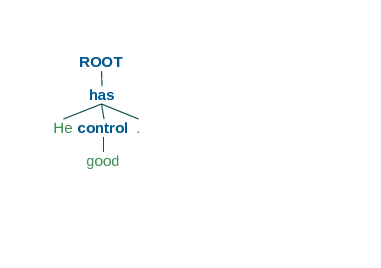

In [9]:
draw_nltk_tree(Tree.fromstring(state.to_tree_string()))

## Data load & Preprocessing 

Get features from stack and buffer. <br>
1.  The top 3 words on the stack and buffer ($s_1,s_2,s_3,b_1,b_2,b_3$)
2. The first and second leftmost / rightmost children of the top two words on the stack: $lc_1(s_i), rc_1(s_i), lTc_2(s_i), rc_2(s_i), i = 1, 2$
3. <i>The leftmost of leftmost / rightmost of rightmost children of the top two words on the stack: $lc_1(lc_1(s_i)), rc_1(rc_1(s_i)), i = 1, 2$. # I don't use these features</i>
4. POS tags for $S^t$
5. <i>corresponding arc labels of words excluding those 6 words on the stack/buffer for $S^l$ # I don't use these features</i>

In [10]:
def get_feat(transition_state, word2index, tag2index, label2index=None):
    word_feats = []
    tag_feats = []
    
    word_feats.append(transition_state.stack[-1][0]) if len(transition_state.stack) >= 1 and \
    transition_state.stack[-1][0] in word2index.keys() else word_feats.append('<NULL>') # s1
    word_feats.append(transition_state.stack[-2][0]) if len(transition_state.stack) >= 2 and \
    transition_state.stack[-2][0] in word2index.keys() else word_feats.append('<NULL>') # s2
    word_feats.append(transition_state.stack[-3][0]) if len(transition_state.stack) >= 3 and \
    transition_state.stack[-3][0] in word2index.keys() else word_feats.append('<NULL>') # s3
    
    tag_feats.append(transition_state.stack[-1][1]) if len(transition_state.stack) >= 1 and \
    transition_state.stack[-1][1] in tag2index.keys() else tag_feats.append('<NULL>') # st1
    tag_feats.append(transition_state.stack[-2][1]) if len(transition_state.stack) >= 2 and \
    transition_state.stack[-2][1] in tag2index.keys() else tag_feats.append('<NULL>') # st2
    tag_feats.append(transition_state.stack[-3][1]) if len(transition_state.stack) >= 3 and \
    transition_state.stack[-3][1] in tag2index.keys() else tag_feats.append('<NULL>') # st3
    
    
    word_feats.append(transition_state.buffer[0][0]) if len(transition_state.buffer) >= 1 and \
    transition_state.buffer[0][0] in word2index.keys() else word_feats.append('<NULL>') # b1
    word_feats.append(transition_state.buffer[1][0]) if len(transition_state.buffer) >= 2 and \
    transition_state.buffer[1][0] in word2index.keys() else word_feats.append('<NULL>') # b2
    word_feats.append(transition_state.buffer[2][0]) if len(transition_state.buffer) >= 3 and \
    transition_state.buffer[2][0] in word2index.keys() else word_feats.append('<NULL>') # b3
    
    tag_feats.append(transition_state.buffer[0][1]) if len(transition_state.buffer) >= 1 and \
    transition_state.buffer[0][1] in tag2index.keys() else tag_feats.append('<NULL>') # bt1
    tag_feats.append(transition_state.buffer[1][1]) if len(transition_state.buffer) >= 2 and \
    transition_state.buffer[1][1] in tag2index.keys() else tag_feats.append('<NULL>') # bt2
    tag_feats.append(transition_state.buffer[2][1]) if len(transition_state.buffer) >= 3 and \
    transition_state.buffer[2][1] in tag2index.keys() else tag_feats.append('<NULL>') # bt3
    
    
    lc_s1 = transition_state.get_left_most(transition_state.stack[-1][2]) if len(transition_state.stack) >= 1 \
    else transition_state.get_left_most(None)
    rc_s1 = transition_state.get_right_most(transition_state.stack[-1][2]) if len(transition_state.stack) >= 1 \
    else transition_state.get_right_most(None)
    
    lc_s2 = transition_state.get_left_most(transition_state.stack[-2][2]) if len(transition_state.stack) >= 2 \
    else transition_state.get_left_most(None)
    rc_s2 = transition_state.get_right_most(transition_state.stack[-2][2]) if len(transition_state.stack) >= 2 \
    else transition_state.get_right_most(None)
    
    words, tags, _ = zip(*[lc_s1, rc_s1, lc_s2, rc_s2])
    
    word_feats.extend(words)
    
    tag_feats.extend(tags)
    
    
    return prepare_sequence(word_feats, word2index).view(1, -1), prepare_sequence(tag_feats, tag2index).view(1, -1)

You can get data from <a href="https://github.com/rguthrie3/DeepDependencyParsingProblemSet">this repo</a>.

In [12]:
data = open('../dataset/dparser/train.txt', 'r').readlines()
vocab = open('../dataset/dparser/vocab.txt', 'r').readlines()

In [13]:
splited_data = [[nltk.pos_tag(d.split('|||')[0].split()), d.split('|||')[1][:-1].split()] for d in data]

### Build Vocab

In [14]:
train_x,train_y = list(zip(*splited_data))
train_x_f = flatten(train_x)
sents, pos_tags = list(zip(*train_x_f))

In [15]:
tag2index = {v:i for i,v in enumerate(set(pos_tags))}
tag2index['<root>'] = len(tag2index)
tag2index['<NULL>'] = len(tag2index)

In [16]:
vocab = [v.split('\t')[0] for v in vocab]
word2index = {v:i for i, v in enumerate(vocab)}
word2index['ROOT'] = len(word2index)
word2index['<NULL>'] = len(word2index)

In [17]:
actions = ['SHIFT', 'REDUCE_L', 'REDUCE_R']
action2index = {v:i for i, v in enumerate(actions)}

In [18]:
train_data = []

In [19]:
for tx, ty in splited_data:
    state = TransitionState(tx)
    transition = ty + ['REDUCE_R'] # root
    while len(transition):
        feat = get_feat(state, word2index, tag2index)
        action = transition.pop(0)
        actionTensor = Variable(LongTensor([action2index[action]])).view(1, -1)
        train_data.append([feat, actionTensor])
        if action == 'SHIFT':
            state.shift()
        elif action == 'REDUCE_R':
            state.right_arc()
        elif action == 'REDUCE_L':
            state.left_arc()

In [20]:
train_data[0]

[(Variable containing:
   9151  9152  9152  2106     2   353  9152  9152  9152  9152
  [torch.cuda.LongTensor of size 1x10 (GPU 0)], Variable containing:
     43    44    44    25    22    26    44    44    44    44
  [torch.cuda.LongTensor of size 1x10 (GPU 0)]), Variable containing:
  0
 [torch.cuda.LongTensor of size 1x1 (GPU 0)]]

## Modeling 

<img src="../images/05.neural-dparser-architecture.png">
<center>borrowed image from http://web.stanford.edu/class/cs224n/lectures/cs224n-2017-lecture6.pdf</center>

In [21]:
class NeuralDependencyParser(nn.Module):
    
    def __init__(self, w_size, w_embed_dim, t_size, t_embed_dim, hidden_size, target_size):
        
        super(NeuralDependencyParser, self).__init__()
        
        self.w_embed =  nn.Embedding(w_size, w_embed_dim)
        self.t_embed = nn.Embedding(t_size, t_embed_dim)
        self.hidden_size = hidden_size
        self.target_size = target_size
        self.linear = nn.Linear((w_embed_dim + t_embed_dim) * 10, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.target_size)
        
        self.w_embed.weight.data.uniform_(-0.01, 0.01) # init
        self.t_embed.weight.data.uniform_(-0.01, 0.01) # init
        
    def forward(self, words, tags):
        
        wem = self.w_embed(words).view(words.size(0), -1)
        tem = self.t_embed(tags).view(tags.size(0), -1)
        inputs = torch.cat([wem, tem], 1)
        h1 = torch.pow(self.linear(inputs), 3) # cube activation function
        preds = -self.out(h1)
        return F.log_softmax(preds,1)

## Training

In [22]:
STEP = 5
BATCH_SIZE = 256
W_EMBED_SIZE = 50
T_EMBED_SIZE = 10
HIDDEN_SIZE = 512
LR = 0.001

In [23]:
model = NeuralDependencyParser(len(word2index), W_EMBED_SIZE, len(tag2index), T_EMBED_SIZE, HIDDEN_SIZE, len(action2index))
if USE_CUDA:
    model = model.cuda()

loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [24]:
losses = []

In [25]:
for i, batch in enumerate(getBatch(BATCH_SIZE, train_data)):
    
    model.zero_grad()
    inputs, targets = list(zip(*batch))
    words, tags = list(zip(*inputs))
    words = torch.cat(words)
    tags = torch.cat(tags)
    targets = torch.cat(targets)
    preds = model(words, tags)
    loss = loss_function(preds, targets.view(-1))
    loss.backward()
    optimizer.step()
    
    losses.append(loss.data.tolist()[0])
    
    if i % 100 == 0:
        print("mean_loss : %0.2f" %(np.mean(losses)))
        losses = []

mean_loss : 1.10
mean_loss : 0.82
mean_loss : 0.38
mean_loss : 0.32
mean_loss : 0.29
mean_loss : 0.27
mean_loss : 0.25
mean_loss : 0.24
mean_loss : 0.23
mean_loss : 0.22
mean_loss : 0.22
mean_loss : 0.21
mean_loss : 0.20
mean_loss : 0.20
mean_loss : 0.19
mean_loss : 0.19


## Test (UAS)

In [26]:
dev = open('../dataset/dparser/dev.txt','r').readlines()

In [27]:
splited_data = [[nltk.pos_tag(d.split('|||')[0].split()), d.split('|||')[1][:-1].split()] for d in dev]

In [28]:
dev_data = []

In [29]:
for tx,ty in splited_data:
    state = TransitionState(tx)
    transition = ty + ['REDUCE_R'] # root
    while len(transition) != 0:
        feat = get_feat(state, word2index, tag2index)
        action = transition.pop(0)
        dev_data.append([feat, action2index[action]])
        if action == 'SHIFT':
            state.shift()
        elif action == 'REDUCE_R':
            state.right_arc()
        elif action == 'REDUCE_L':
            state.left_arc()

In [30]:
accuracy = 0

In [31]:
for dev in dev_data:
    input, target = dev[0], dev[1]
    word, tag = input[0], input[1]
    pred = model(word, tag).max(1)[1]
    pred = pred.data.tolist()[0]
    if pred == target:
        accuracy += 1

print(accuracy/len(dev_data) * 100)

91.6377171215881


## Plotting parsed result

In [32]:
test = TransitionState(nltk.pos_tag("I shot an elephant in my pajamas".split()))

In [33]:
index2action = {i:v for v, i in action2index.items()}

In [34]:
while test.is_done() == False:
    feat = get_feat(test, word2index, tag2index)
    word, tag = feat[0], feat[1]
    action = model(word, tag).max(1)[1].data.tolist()[0]
    
    action = index2action[action]
    
    if action == 'SHIFT':
        test.shift()
    elif action == 'REDUCE_R':
        test.right_arc()
    elif action == 'REDUCE_L':
        test.left_arc()

In [35]:
print(test)

stack : ['ROOT'] 
buffer : []


In [36]:
test.to_tree_string()

'(ROOT (shot I (elephant an) (in (pajamas my))))'

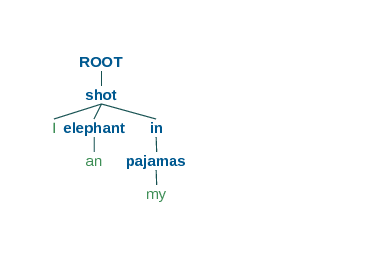

In [37]:
draw_nltk_tree(Tree.fromstring(test.to_tree_string()))

## Further Topics

* <a href="https://arxiv.org/pdf/1506.06158.pdf">Structured Training for Neural Network Transition-Based Parsing</a>
* <a href="https://arxiv.org/pdf/1703.04474">DRAGNN: A Transition-based Framework for Dynamically Connected Neural Networks</a>